# DrivenData Machine Learning with a Heart
Detect heart disease from patient cardiovascular dataset. The objective of this project is to predict the binary class, `heart_disease_present`, which represents whether or not a patient has heart disease:
- `0` represents no heart disease present
- `1` represents heart disease present

DrivenData [competition info here](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/page/107/); data provided by [Cleveland Heart Disease Database](http://archive.ics.uci.edu/ml/datasets/statlog+(heart)) via the UCI Machine Learning repository

- Invert values for `num_major_vessels` (0-3) values should change to (3-0) ie 1 changes to 2, 0, changes to 3
- Invert values for `ST_depression` - values represent where ST segment is abnormally low below baseline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder, KBinsDiscretizer

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/train_values.csv')
labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/train_labels.csv')
labels.drop(['patient_id'],axis=1,inplace=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

In [4]:
X_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
117,9dqkpy,1,reversible_defect,110,4,0,0,2,172,0.0,1,41,158,0
65,nck22c,1,reversible_defect,126,4,0,0,2,282,0.0,1,35,156,1
67,f70grj,2,normal,115,4,0,0,0,303,1.2,1,43,181,0
31,z7xkou,2,reversible_defect,150,4,3,0,2,225,1.0,0,65,114,0
12,mpggsq,1,normal,140,3,0,0,0,335,0.0,1,64,158,0


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 117 to 102
Data columns (total 14 columns):
patient_id                              144 non-null object
slope_of_peak_exercise_st_segment       144 non-null int64
thal                                    144 non-null object
resting_blood_pressure                  144 non-null int64
chest_pain_type                         144 non-null int64
num_major_vessels                       144 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    144 non-null int64
resting_ekg_results                     144 non-null int64
serum_cholesterol_mg_per_dl             144 non-null int64
oldpeak_eq_st_depression                144 non-null float64
sex                                     144 non-null int64
age                                     144 non-null int64
max_heart_rate_achieved                 144 non-null int64
exercise_induced_angina                 144 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 16.9+ KB

In [6]:
X_train.drop(['patient_id'],axis=1,inplace=True)

/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
X_train.loc[:,'thal'] = X_train.loc[:,'thal'].astype('category')

/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
X_train.loc[:,'chest_pain_type'] = X_train.loc[:,'chest_pain_type'].astype('category')

In [9]:
X_train['thal'].value_counts()

normal               79
reversible_defect    58
fixed_defect          7
Name: thal, dtype: int64

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 117 to 102
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       144 non-null int64
thal                                    144 non-null category
resting_blood_pressure                  144 non-null int64
chest_pain_type                         144 non-null category
num_major_vessels                       144 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    144 non-null int64
resting_ekg_results                     144 non-null int64
serum_cholesterol_mg_per_dl             144 non-null int64
oldpeak_eq_st_depression                144 non-null float64
sex                                     144 non-null int64
age                                     144 non-null int64
max_heart_rate_achieved                 144 non-null int64
exercise_induced_angina                 144 non-null int64
dtypes: category(2), float64(1), int64(10)
memory usage: 14.1 KB


In [11]:
#X_train = pd.get_dummies(X_train)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 117 to 102
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       144 non-null int64
thal                                    144 non-null category
resting_blood_pressure                  144 non-null int64
chest_pain_type                         144 non-null category
num_major_vessels                       144 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    144 non-null int64
resting_ekg_results                     144 non-null int64
serum_cholesterol_mg_per_dl             144 non-null int64
oldpeak_eq_st_depression                144 non-null float64
sex                                     144 non-null int64
age                                     144 non-null int64
max_heart_rate_achieved                 144 non-null int64
exercise_induced_angina                 144 non-null int64
dtypes: category(2), float64(1), int64(10)
memory usage: 14.1 KB


In [13]:
X_train.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1.527778,131.472222,0.694444,0.166667,1.006944,246.409722,0.960417,0.673611,55.020833,149.694444,0.326389
std,0.636253,17.078160,0.977207,0.373979,0.999976,47.140827,1.109981,0.470528,9.004637,22.091443,0.470528
min,1.000000,94.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,34.000000,96.000000,0.000000
25%,1.000000,120.000000,0.000000,0.000000,0.000000,212.750000,0.000000,0.000000,48.750000,136.250000,0.000000
50%,1.000000,130.000000,0.000000,0.000000,1.500000,245.500000,0.600000,1.000000,56.000000,152.500000,0.000000
75%,2.000000,140.000000,1.000000,0.000000,2.000000,277.000000,1.525000,1.000000,62.000000,166.250000,1.000000
max,3.000000,180.000000,3.000000,1.000000,2.000000,417.000000,6.200000,1.000000,77.000000,192.000000,1.000000


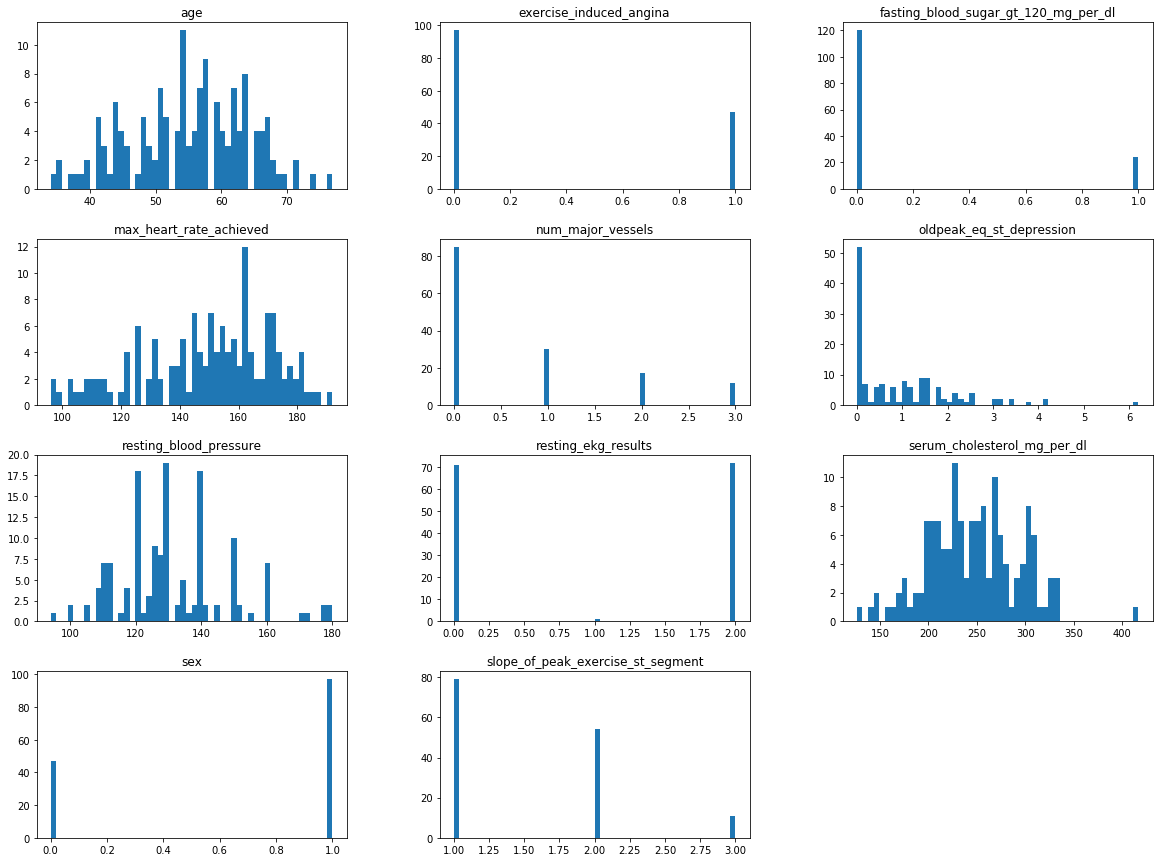

In [14]:
X_train.hist(bins=50, figsize=(20,15),grid=False)
plt.show()

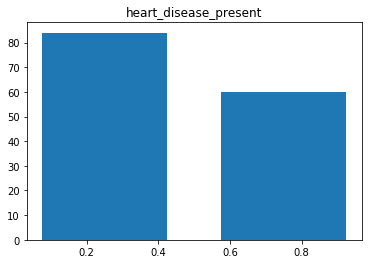

In [15]:
y_train.hist(bins=2,rwidth=.7,grid=False)
plt.show()

In [16]:
def get_cat_num_labels(df):
    num = []
    cat = []
    for col in df.columns:
        print(col)
        print(df[col].dtype)
        if df[col].dtype == 'float64':
            num.append(col)
            print("Num")
        elif df[col].dtype == 'int64':
            num.append(col)
            print("Num")
        else:
            cat.append(col)
            print("Cat")
        print("")
    return num, cat

In [17]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [18]:
num, cat = get_cat_num_labels(X_train)

slope_of_peak_exercise_st_segment
int64
Num

thal
category
Cat

resting_blood_pressure
int64
Num

chest_pain_type
category
Cat

num_major_vessels
int64
Num

fasting_blood_sugar_gt_120_mg_per_dl
int64
Num

resting_ekg_results
int64
Num

serum_cholesterol_mg_per_dl
int64
Num

oldpeak_eq_st_depression
float64
Num

sex
int64
Num

age
int64
Num

max_heart_rate_achieved
int64
Num

exercise_induced_angina
int64
Num



In [19]:
num

['slope_of_peak_exercise_st_segment',
 'resting_blood_pressure',
 'num_major_vessels',
 'fasting_blood_sugar_gt_120_mg_per_dl',
 'resting_ekg_results',
 'serum_cholesterol_mg_per_dl',
 'oldpeak_eq_st_depression',
 'sex',
 'age',
 'max_heart_rate_achieved',
 'exercise_induced_angina']

In [20]:
cat

['thal', 'chest_pain_type']

In [21]:
num_pipeline = Pipeline([
    ('df_selector',DataFrameSelector(num)),
    ('Normalizer', MinMaxScaler(feature_range=(0,1))),
])

cat_pipeline = Pipeline([
    ('df_selector',DataFrameSelector(cat)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

pipe = Pipeline([('feats',FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline',cat_pipeline),
])),
    ('poly',PolynomialFeatures(2)),
    #('Normalizer', MinMaxScaler(feature_range=(0,1))),
                ])

In [ ]:
#train = X_train.copy()
#train['heart_disease_present'] = y_train['heart_disease_present'].copy()

In [22]:
corr_matrix = X_train.corr()

In [23]:
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
slope_of_peak_exercise_st_segment,1,0.1,0.07,0.069,0.16,-0.039,0.59,0.089,0.19,-0.42,0.21
resting_blood_pressure,0.1,1,0.033,0.13,0.029,0.19,0.25,-0.091,0.22,-0.054,0.1
num_major_vessels,0.07,0.033,1,0.18,0.095,0.13,0.22,0.071,0.34,-0.29,0.2
fasting_blood_sugar_gt_120_mg_per_dl,0.069,0.13,0.18,1,-0.0031,0.014,0.0042,0.11,0.097,0.076,0.0066
resting_ekg_results,0.16,0.029,0.095,-0.0031,1,0.16,0.14,0.094,0.086,-0.12,0.084
serum_cholesterol_mg_per_dl,-0.039,0.19,0.13,0.014,0.16,1,-0.035,-0.12,0.19,-0.14,0.16
oldpeak_eq_st_depression,0.59,0.25,0.22,0.0042,0.14,-0.035,1,0.059,0.23,-0.32,0.19
sex,0.089,-0.091,0.071,0.11,0.094,-0.12,0.059,1,-0.14,-0.031,0.23
age,0.19,0.22,0.34,0.097,0.086,0.19,0.23,-0.14,1,-0.43,0.11
max_heart_rate_achieved,-0.42,-0.054,-0.29,0.076,-0.12,-0.14,-0.32,-0.031,-0.43,1,-0.39


In [24]:
y_train = y_train['heart_disease_present'].values

In [25]:
X_train2 = pipe.fit_transform(X_train)

### Model Evaluation

In [26]:
scores_df = pd.DataFrame()

In [27]:
sgd_cvs = cross_val_score(SGDClassifier(max_iter=1000,tol=0.001,random_state=42), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['SGD'] = sgd_cvs

In [28]:
log_cvs = cross_val_score(LogisticRegression(solver='lbfgs',random_state=42), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['Logistic Regression'] = log_cvs

In [29]:
tree_cvs = cross_val_score(DecisionTreeClassifier(random_state=42), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['Decision Tree'] = tree_cvs

In [30]:
svc_cvs = cross_val_score(SVC(gamma='auto',random_state=42), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['SVC'] = svc_cvs

In [31]:
svp_cvs = cross_val_score(SVC(kernel='poly',gamma='auto',random_state=42), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['SVC Poly'] = svp_cvs

In [32]:
knn_cvs = cross_val_score(KNeighborsClassifier(), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['KNN'] = knn_cvs

In [33]:
for_cvs = cross_val_score(RandomForestClassifier(n_estimators=100,random_state=42), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['Forest'] = for_cvs

In [34]:
xtr_cvs = cross_val_score(ExtraTreesClassifier(n_estimators=1000,random_state=42), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['Extra Trees'] = xtr_cvs

In [35]:
ada_cvs = cross_val_score(AdaBoostClassifier(random_state=42), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['Adaboost'] = ada_cvs

In [36]:
xgb_cvs = cross_val_score(XGBClassifier(), X_train2, y_train, cv=5, scoring="roc_auc")
scores_df['XGBoost'] = xgb_cvs

In [37]:
scores_df.describe()[1:]

,SGD,Logistic Regression,Decision Tree,SVC,SVC Poly,KNN,Forest,Extra Trees,Adaboost,XGBoost
mean,0.846017,0.865686,0.696569,0.882659,0.886581,0.821936,0.890625,0.882598,0.792157,0.848284
std,0.020456,0.036122,0.058475,0.039336,0.040562,0.052424,0.039952,0.032474,0.089627,0.074465
min,0.823529,0.828431,0.644608,0.848039,0.838235,0.769608,0.850490,0.862745,0.676471,0.745098
25%,0.828125,0.833333,0.644608,0.857843,0.857843,0.789216,0.862745,0.862745,0.745098,0.813725
50%,0.848039,0.872549,0.698529,0.862745,0.892157,0.816176,0.887255,0.862745,0.799020,0.848039
75%,0.857843,0.877451,0.708333,0.901961,0.901961,0.828431,0.899510,0.887255,0.823529,0.897059
max,0.872549,0.916667,0.786765,0.942708,0.942708,0.906250,0.953125,0.937500,0.916667,0.937500


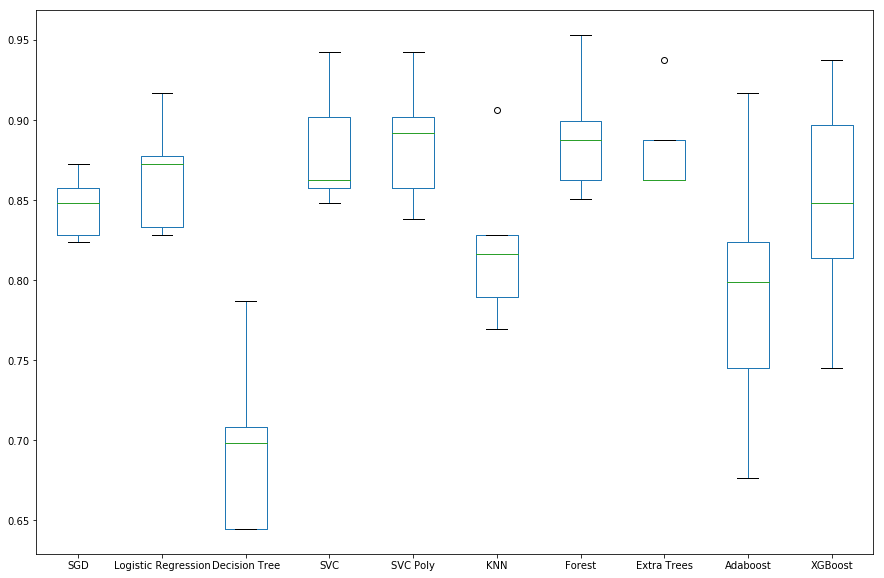

In [38]:
scores_df.plot(kind='box', figsize=(15,10))

### Hyperparameter Tuning

#### XGBoost

In [ ]:
param_grid = [
    {'max_depth':[3,6,10,15],
     'n_estimators':[10,100,500,1000],
     'gamma':[0,0.5,1]
    }
]

In [ ]:
grid_search = GridSearchCV(XGBClassifier(n_jobs=-1), param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train2, y_train)

In [ ]:
cvres = grid_search.cv_results_

In [ ]:
cvres = grid_search.cv_results_
cv_results = sorted([(x,y) for x,y in zip(cvres["mean_test_score"],cvres["params"])],key=lambda x: x[0],reverse=True)
for AUC, params in cv_results:
    print(round(AUC,5), params)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

#### Extra Trees

In [39]:
param_grid = [
    {'max_depth':[2,3],
     'n_estimators':[200,225,250,500,1000,1500],
     'bootstrap':[True,False],
    }
]

In [40]:
grid_search_xtr = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), param_grid, cv=5, scoring="roc_auc")
grid_search_xtr.fit(X_train2, y_train)

/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [2, 3], 'n_estimators': [200, 225, 250, 500, 1000, 1500], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [41]:
grid_search_xtr.best_score_

0.9010501770152506

In [42]:
cvres_xtr = grid_search_xtr.cv_results_
cv_results_xtr = sorted([(x,y) for x,y in zip(cvres_xtr["mean_test_score"],cvres_xtr["params"])],key=lambda x: x[0],reverse=True)
for AUC, params in cv_results_xtr:
    print(round(AUC,5), params)

0.90105 {'bootstrap': True, 'max_depth': 2, 'n_estimators': 1500}
0.89811 {'bootstrap': True, 'max_depth': 2, 'n_estimators': 225}
0.89713 {'bootstrap': False, 'max_depth': 2, 'n_estimators': 250}
0.8971 {'bootstrap': True, 'max_depth': 2, 'n_estimators': 1000}
0.89614 {'bootstrap': True, 'max_depth': 2, 'n_estimators': 250}
0.89611 {'bootstrap': True, 'max_depth': 3, 'n_estimators': 250}
0.89611 {'bootstrap': False, 'max_depth': 2, 'n_estimators': 225}
0.89611 {'bootstrap': True, 'max_depth': 2, 'n_estimators': 500}
0.89518 {'bootstrap': True, 'max_depth': 3, 'n_estimators': 1000}
0.89417 {'bootstrap': True, 'max_depth': 3, 'n_estimators': 200}
0.89414 {'bootstrap': False, 'max_depth': 2, 'n_estimators': 200}
0.89409 {'bootstrap': False, 'max_depth': 3, 'n_estimators': 500}
0.89318 {'bootstrap': True, 'max_depth': 3, 'n_estimators': 500}
0.89318 {'bootstrap': True, 'max_depth': 3, 'n_estimators': 1500}
0.89313 {'bootstrap': False, 'max_depth': 2, 'n_estimators': 1500}
0.89217 {'bootst

In [43]:
final_model = grid_search_xtr.best_estimator_

### Generate predictions on test_values dataset

In [44]:
test_values = pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/test_values.csv')

In [45]:
test_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 14 columns):
patient_id                              90 non-null object
slope_of_peak_exercise_st_segment       90 non-null int64
thal                                    90 non-null object
resting_blood_pressure                  90 non-null int64
chest_pain_type                         90 non-null int64
num_major_vessels                       90 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    90 non-null int64
resting_ekg_results                     90 non-null int64
serum_cholesterol_mg_per_dl             90 non-null int64
oldpeak_eq_st_depression                90 non-null float64
sex                                     90 non-null int64
age                                     90 non-null int64
max_heart_rate_achieved                 90 non-null int64
exercise_induced_angina                 90 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 9.9+ KB


In [46]:
test_values.loc[:,'thal'] = test_values.loc[:,'thal'].astype('category')
test_values.loc[:,'chest_pain_type'] = test_values.loc[:,'chest_pain_type'].astype('category')

In [47]:
test_ids = test_values['patient_id']
test_values = test_values.drop('patient_id',axis=1)

In [48]:
test_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       90 non-null int64
thal                                    90 non-null category
resting_blood_pressure                  90 non-null int64
chest_pain_type                         90 non-null category
num_major_vessels                       90 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    90 non-null int64
resting_ekg_results                     90 non-null int64
serum_cholesterol_mg_per_dl             90 non-null int64
oldpeak_eq_st_depression                90 non-null float64
sex                                     90 non-null int64
age                                     90 non-null int64
max_heart_rate_achieved                 90 non-null int64
exercise_induced_angina                 90 non-null int64
dtypes: category(2), float64(1), int64(10)
memory usage: 8.3 KB


In [49]:
input_ = pipe.transform(test_values)
input_.shape

(90, 190)

In [50]:
test_values.shape

(90, 13)

In [51]:
X_train.shape

(144, 13)

In [52]:
X_train2.shape

(144, 190)

In [53]:
final_model.predict(input_)

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0])

In [54]:
test_probas = final_model.predict_proba(input_)

In [55]:
test_probas

array([[0.57586528, 0.42413472],
       [0.77746344, 0.22253656],
       [0.22384695, 0.77615305],
       [0.828683  , 0.171317  ],
       [0.38580398, 0.61419602],
       [0.8414793 , 0.1585207 ],
       [0.76499464, 0.23500536],
       [0.42270534, 0.57729466],
       [0.72323547, 0.27676453],
       [0.83886317, 0.16113683],
       [0.7819501 , 0.2180499 ],
       [0.53204724, 0.46795276],
       [0.56482368, 0.43517632],
       [0.25005963, 0.74994037],
       [0.74639235, 0.25360765],
       [0.85145698, 0.14854302],
       [0.84657135, 0.15342865],
       [0.81284535, 0.18715465],
       [0.46801336, 0.53198664],
       [0.84649519, 0.15350481],
       [0.17486724, 0.82513276],
       [0.72965426, 0.27034574],
       [0.79650874, 0.20349126],
       [0.8378357 , 0.1621643 ],
       [0.4944742 , 0.5055258 ],
       [0.32796362, 0.67203638],
       [0.58213448, 0.41786552],
       [0.73626649, 0.26373351],
       [0.51286495, 0.48713505],
       [0.84344873, 0.15655127],
       [0.

In [56]:
heart_disease_probas = [y for x,y in test_probas]

In [57]:
out_df = pd.DataFrame({'patient_id':test_ids,'heart_disease_present':heart_disease_probas})
out_df

,patient_id,heart_disease_present
0,olalu7,0.424135
1,z9n6mx,0.222537
2,5k4413,0.776153
3,mrg7q5,0.171317
4,uki4do,0.614196
5,kev1sk,0.158521
6,9n6let,0.235005
7,jxmtyg,0.577295
8,51s2ff,0.276765
9,wi9mcs,0.161137


In [58]:
out_df.to_csv('submission2.csv',index=False)